## 1. Convert dataset format

Unsloth expects instruction–response pairs typically in .jsonl, each entry with "instruction", "input" (optional), and "output". Your data has "input": "", which is acceptable. Let’s convert to .jsonl.

In [4]:
import json, random
data = json.load(open('metal.json'))
random.shuffle(data)
n = len(data)
split = int(n * 0.99)
train, test = data[:split], data[split:]
json.dump(train, open('train.json','w'), indent=2)
json.dump(test, open('test.json','w'), indent=2)

print("cell executed")


cell executed


## Data Prep

In [2]:
# data = json.load(open('metal.json'))
# with open('metal_train.jsonl', 'w') as ft, open('metal_test.jsonl','w') as fs:
#     for ex in train:
#         ft.write(json.dumps({
#             "instruction": ex["instruction"],
#             "input": ex["input"] or None,
#             "output": ex["output"]
#         }) + "\n")
#     for ex in test:
#         fs.write(json.dumps({
#             "instruction": ex["instruction"],
#             "input": ex["input"] or None,
#             "output": ex["output"]
#         }) + "\n")
# print("cell executed")

import json

# Define the Alpaca-style prompt
alpaca_prompt = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
{}

### Input:
{}

### Response:
{}"""

# Replace this with your tokenizer.eos_token if available
EOS_TOKEN = "<|eos|>"

# Load train and test JSON files
with open("train.json", "r") as f:
    train_data = json.load(f)

with open("test.json", "r") as f:
    test_data = json.load(f)

# Function to convert examples to Alpaca-style text
def convert_to_alpaca(data_list):
    formatted = []
    for ex in data_list:
        instruction = ex["instruction"].strip()
        input_ = ex["input"].strip() if ex["input"] else ""
        output = ex["output"].strip()
        text = alpaca_prompt.format(instruction, input_, output) + EOS_TOKEN
        formatted.append({ "text": text })
    return formatted

# Write formatted data to new .jsonl files
with open("train_alpaca.jsonl", "w") as ft:
    for item in convert_to_alpaca(train_data):
        ft.write(json.dumps(item) + "\n")

with open("test_alpaca.jsonl", "w") as fs:
    for item in convert_to_alpaca(test_data):
        fs.write(json.dumps(item) + "\n")

print("✅ Successfully converted to Alpaca-style JSONL files.")



✅ Successfully converted to Alpaca-style JSONL files.


## 2. Generate raw base-model outputs
Load the base unsloth/Meta-Llama-3.1-8B-bnb-4bit model (QLoRA-ready) and generate responses to your test set. Save them as llama3_raw.json.

In [3]:
%%capture
import os
if "COLAB_" not in "".join(os.environ.keys()):
    !pip install unsloth
else:
    # Do this only in Colab notebooks! Otherwise use pip install unsloth
    !pip install --no-deps bitsandbytes accelerate xformers==0.0.29.post3 peft trl triton cut_cross_entropy unsloth_zoo
    !pip install sentencepiece protobuf "datasets>=3.4.1" huggingface_hub hf_transfer
    !pip install --no-deps unsloth

In [4]:
from unsloth import FastLanguageModel
import torch
max_seq_length = 2048 # Choose any! We auto support RoPE Scaling internally!
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.

# 4bit pre quantized models we support for 4x faster downloading + no OOMs.
fourbit_models = [
    "unsloth/Meta-Llama-3.1-8B-bnb-4bit",      # Llama-3.1 15 trillion tokens model 2x faster!
    "unsloth/Meta-Llama-3.1-8B-Instruct-bnb-4bit",
    "unsloth/Meta-Llama-3.1-70B-bnb-4bit",
    "unsloth/Meta-Llama-3.1-405B-bnb-4bit",    # We also uploaded 4bit for 405b!
    "unsloth/Mistral-Nemo-Base-2407-bnb-4bit", # New Mistral 12b 2x faster!
    "unsloth/Mistral-Nemo-Instruct-2407-bnb-4bit",
    "unsloth/mistral-7b-v0.3-bnb-4bit",        # Mistral v3 2x faster!
    "unsloth/mistral-7b-instruct-v0.3-bnb-4bit",
    "unsloth/Phi-3.5-mini-instruct",           # Phi-3.5 2x faster!
    "unsloth/Phi-3-medium-4k-instruct",
    "unsloth/gemma-2-9b-bnb-4bit",
    "unsloth/gemma-2-27b-bnb-4bit",            # Gemma 2x faster!
] # More models at https://huggingface.co/unsloth

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/Meta-Llama-3.1-8B-Instruct-bnb-4bit",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
    # token = "hf_...", # use one if using gated models like meta-llama/Llama-2-7b-hf
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.6.2: Fast Llama patching. Transformers: 4.52.4.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/5.70G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/55.5k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/454 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

In [5]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 16, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    # [NEW] "unsloth" uses 30% less VRAM, fits 2x larger batch sizes!
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
)

Unsloth 2025.6.2 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


Unsloth with QLoRA is ~2× faster, ~60 % memory-efficient compared to HF+FA2 and supports extended context. It runs comfortably even on Colab T4/A100

### Train the model

In [9]:
from datasets import load_dataset
from trl import SFTTrainer
from transformers import TrainingArguments
from unsloth import is_bfloat16_supported

# Load your alpaca-style formatted dataset
dataset = load_dataset("json", data_files="train_alpaca.jsonl", split="train")

# Now set up SFTTrainer as you had before
trainer = SFTTrainer(
    model=model,
    tokenizer=tokenizer,
    train_dataset=dataset,
    dataset_text_field="text",
    max_seq_length=max_seq_length,
    dataset_num_proc=2,
    packing=False,  # Can make training 5x faster for short sequences
    args=TrainingArguments(
        per_device_train_batch_size=2,
        gradient_accumulation_steps=4,
        warmup_steps=5,
        num_train_epochs = 1,  # Set this if you want full epochs instead of max_steps
        # max_steps=60,
        learning_rate=2e-4,
        fp16=not is_bfloat16_supported(),
        bf16=is_bfloat16_supported(),
        logging_steps=1,
        optim="adamw_8bit",
        weight_decay=0.01,
        lr_scheduler_type="linear",
        seed=3407,
        output_dir="outputs",
        report_to="none",  # Use 'wandb' or others if needed
    ),
)


Unsloth: Tokenizing ["text"]:   0%|          | 0/5034 [00:00<?, ? examples/s]

In [10]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 5,034 | Num Epochs = 1 | Total steps = 630
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 41,943,040/8,000,000,000 (0.52% trained)


Step,Training Loss
1,3.164300
2,3.119800
3,2.949100
4,2.571200
5,2.128900
6,1.577300
7,1.229500
8,0.906300
9,0.651000
10,0.566300


In [12]:
# @title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = Tesla T4. Max memory = 14.741 GB.
6.883 GB of memory reserved.


In [13]:
# @title Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory / max_memory * 100, 3)
lora_percentage = round(used_memory_for_lora / max_memory * 100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(
    f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training."
)
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

2597.287 seconds used for training.
43.29 minutes used for training.
Peak reserved memory = 6.883 GB.
Peak reserved memory for training = 0.0 GB.
Peak reserved memory % of max memory = 46.693 %.
Peak reserved memory for training % of max memory = 0.0 %.


#### Inference

In [17]:
# alpaca_prompt = Copied from above
FastLanguageModel.for_inference(model) # Enable native 2x faster inference
inputs = tokenizer(
[
    alpaca_prompt.format(
        "Given composition, is it metal? ->", # instruction
        "ThRh2\n", # input
        "", # output - leave this blank for generation!
    )
], return_tensors = "pt").to("cuda")

outputs = model.generate(**inputs, max_new_tokens = 64, use_cache = True)
tokenizer.batch_decode(outputs)

['<|begin_of_text|>Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.\n\n### Instruction:\nGiven composition, is it metal? ->\n\n### Input:\nThRh2\n\n\n### Response:\nYes, ThRh2 is metal.<|eos|><|end_of_text|>']

## 4. Generate fine-tuned outputs
Load the fine-tuned model and generate responses on your test set:

In [22]:
import json
import torch
from transformers import TextStreamer
from unsloth import FastLanguageModel
from tqdm import tqdm

# Enable faster inference
FastLanguageModel.for_inference(model)

# Alpaca-style prompt
alpaca_prompt = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
{}

### Input:
{}

### Response:
{}"""

# Load test data
with open("test.json", "r") as f:
    test_data = json.load(f)

finetuned_outputs = []

# Inference loop
for item in tqdm(test_data):
    prompt = alpaca_prompt.format(
        item["instruction"].strip(),
        item["input"].strip() if item["input"] else "",
        ""  # leave response blank
    )

    # Tokenize input
    inputs = tokenizer([prompt], return_tensors="pt").to("cuda")

    # Generate output
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=64,
            use_cache=True,
            do_sample=False,
            temperature=0.0,
        )

    decoded = tokenizer.batch_decode(outputs, skip_special_tokens=True)[0]
    response = decoded.split("### Response:")[-1].strip()

    # Save full record
    finetuned_outputs.append({
        "instruction": item["instruction"],
        "input": item["input"],
        "ground_truth": item["output"],
        "finetuned_output": response
    })

# Save to file
with open("llma_finetuned.json", "w") as f:
    json.dump(finetuned_outputs, f, indent=2)

print("✅ Saved fine-tuned model outputs to llma_finetuned.json")


100%|██████████| 51/51 [01:09<00:00,  1.36s/it]

✅ Saved fine-tuned model outputs to llma_finetuned.json


In [24]:
model.save_pretrained("lora_model")  # Local saving
tokenizer.save_pretrained("lora_model")
# model.push_to_hub("your_name/lora_model", token = "...") # Online saving
# tokenizer.push_to_hub("your_name/lora_model", token = "...") # Online saving

('lora_model/tokenizer_config.json',
 'lora_model/special_tokens_map.json',
 'lora_model/chat_template.jinja',
 'lora_model/tokenizer.json')

## 5. Evaluate & Compare
Manual review to compare base (llama3_raw.json) vs fine-tuned (llama3_finetune.json) outputs against your true responses.

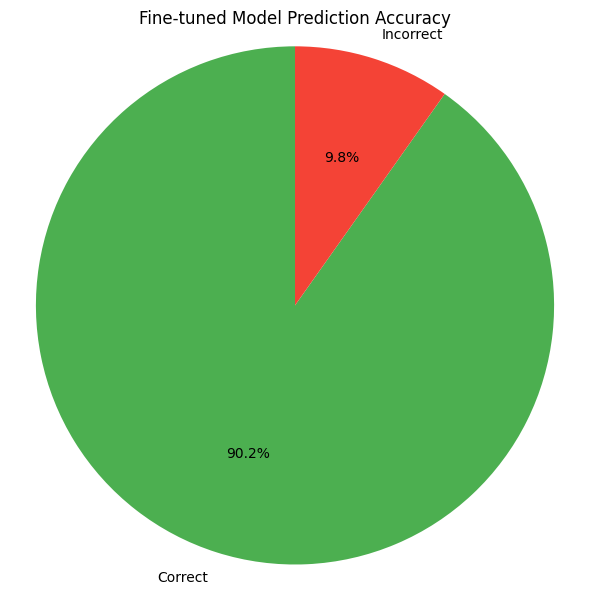

📊 Evaluation Metrics:
✅ Accuracy:  0.9020
🎯 Precision: 0.9231
📥 Recall:    0.8889
📈 F1 Score:  0.9057


In [23]:
import json
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Load predictions
with open("llma_finetuned.json", "r") as f:
    data = json.load(f)

# Function to normalize Yes/No outputs
def normalize_answer(s):
    s = s.lower().strip()
    if "yes" in s:
        return "yes"
    elif "no" in s:
        return "no"
    else:
        return "unknown"

y_true = [normalize_answer(ex["ground_truth"]) for ex in data]
y_pred = [normalize_answer(ex["finetuned_output"]) for ex in data]

# Filter out any unknowns
filtered = [(yt, yp) for yt, yp in zip(y_true, y_pred) if yt in ["yes", "no"] and yp in ["yes", "no"]]
y_true_filtered, y_pred_filtered = zip(*filtered)

# Compute classification metrics
accuracy = accuracy_score(y_true_filtered, y_pred_filtered)
precision, recall, f1, _ = precision_recall_fscore_support(
    y_true_filtered, y_pred_filtered, average='binary', pos_label='yes'
)

# Count correct and incorrect
correct = sum(yt == yp for yt, yp in zip(y_true_filtered, y_pred_filtered))
incorrect = len(y_true_filtered) - correct

# 📊 Plotting
labels = ['Correct', 'Incorrect']
sizes = [correct, incorrect]
colors = ['#4CAF50', '#F44336']

plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, startangle=90)
plt.title('Fine-tuned Model Prediction Accuracy')
plt.axis('equal')
plt.tight_layout()
plt.savefig("accuracy_pie_chart.png")
plt.show()

# Print scores
print("📊 Evaluation Metrics:")
print(f"✅ Accuracy:  {accuracy:.4f}")
print(f"🎯 Precision: {precision:.4f}")
print(f"📥 Recall:    {recall:.4f}")
print(f"📈 F1 Score:  {f1:.4f}")


## Comparing the llma 3 non finetuned ,

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.6.2: Fast Llama patching. Transformers: 4.52.4.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Generating outputs...: 100%|██████████| 51/51 [03:12<00:00,  3.77s/it]

✅ Saved raw model predictions to llma_raw.json


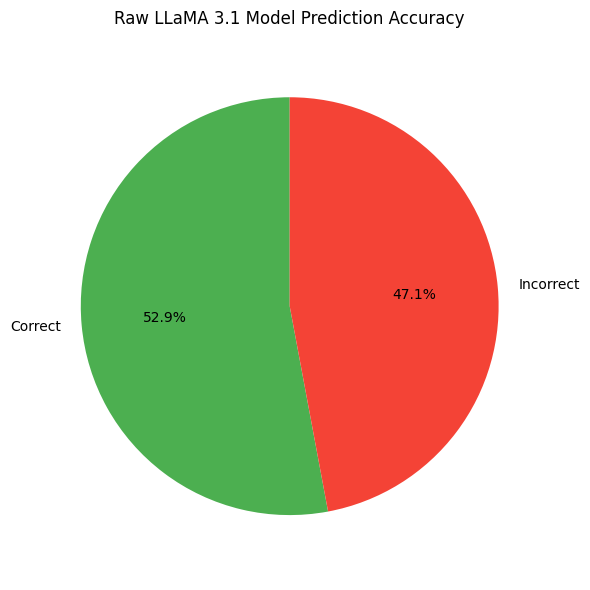

📊 Raw Model Evaluation:
✅ Accuracy:  0.5294
🎯 Precision: 0.5294
📥 Recall:    1.0000
📈 F1 Score:  0.6923


In [1]:
import json
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from unsloth import FastLanguageModel

# STEP 1: Load raw LLaMA 3.1 8B model
max_seq_length = 2048
dtype = None
load_in_4bit = True

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/Meta-Llama-3.1-8B-Instruct-bnb-4bit",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
)

FastLanguageModel.for_inference(model)  # Enable 2x speed

# STEP 2: Define Alpaca prompt
alpaca_prompt = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
{}

### Input:
{}

### Response:
{}"""

# STEP 3: Load test data
with open("test.json", "r") as f:
    test_data = json.load(f)

raw_outputs = []

# STEP 4: Generate predictions
for item in tqdm(test_data, desc="Generating outputs..."):
    prompt = alpaca_prompt.format(
        item["instruction"].strip(),
        item["input"].strip() if item["input"] else "",
        ""
    )

    inputs = tokenizer([prompt], return_tensors="pt").to("cuda")

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=64,
            use_cache=True,
            do_sample=False,
            temperature=0.0
        )

    decoded = tokenizer.batch_decode(outputs, skip_special_tokens=True)[0]
    response = decoded.split("### Response:")[-1].strip()

    raw_outputs.append({
        "instruction": item["instruction"],
        "input": item["input"],
        "ground_truth": item["output"],
        "raw_output": response
    })

# STEP 5: Save results
with open("llma_raw.json", "w") as f:
    json.dump(raw_outputs, f, indent=2)

print("✅ Saved raw model predictions to llma_raw.json")

# STEP 6: Evaluate
def normalize_answer(s):
    s = s.lower().strip()
    if "yes" in s:
        return "yes"
    elif "no" in s:
        return "no"
    return "unknown"

y_true = [normalize_answer(d["ground_truth"]) for d in raw_outputs]
y_pred = [normalize_answer(d["raw_output"]) for d in raw_outputs]

filtered = [(yt, yp) for yt, yp in zip(y_true, y_pred) if yt in ["yes", "no"] and yp in ["yes", "no"]]
y_true_filtered, y_pred_filtered = zip(*filtered)

accuracy = accuracy_score(y_true_filtered, y_pred_filtered)
precision, recall, f1, _ = precision_recall_fscore_support(
    y_true_filtered, y_pred_filtered, average="binary", pos_label="yes"
)

# Count correct/incorrect
correct = sum(yt == yp for yt, yp in zip(y_true_filtered, y_pred_filtered))
incorrect = len(y_true_filtered) - correct

# STEP 7: Plot pie chart
labels = ['Correct', 'Incorrect']
sizes = [correct, incorrect]
colors = ['#4CAF50', '#F44336']

plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, startangle=90)
plt.title('Raw LLaMA 3.1 Model Prediction Accuracy')
plt.axis('equal')
plt.tight_layout()
plt.savefig("llma_raw_accuracy_pie.png")
plt.show()

# STEP 8: Print metrics
print("📊 Raw Model Evaluation:")
print(f"✅ Accuracy:  {accuracy:.4f}")
print(f"🎯 Precision: {precision:.4f}")
print(f"📥 Recall:    {recall:.4f}")
print(f"📈 F1 Score:  {f1:.4f}")
